In [30]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.integrate as integrate
from scipy.interpolate import interp1d
import math
import csv

# import classes from TOVsolver (credit: https://github.com/amotornenko/TOVsolver)
from tov import *
from constants import *

In [31]:
# constants 

# values from pQCD and χEFT
muPQCD, nPQCD, pPQCD = 2.6, 6.47, 3823*10**-3 # pQCD X=2
ePQCD = -pPQCD+nPQCD*muPQCD
muL, nL, pL = 0.978, 0.176, 3.542*10**-3 # stiff causality constraints
eL = -pL+nL*muL

# file name of generated EOS data
filename='generated_EOSs'

In [32]:
# Komoltsev & Kurkela (2022) interpolation method
def kk2022interpolation(cs2lim, muH, nH, pH, eH, isMin=False):
    if (muH < muL): return # exclude values where calculated muH from generated values is unphysical
    if (pH < pL + 0.1): return # exclude pressure values too close or less than lower value 
    if (eH < 0): return # exclude unphysical energy density values
    if (pH > muH*nH/2): return # exclude pressure difference cannot be reached
    if (eH-eL < pH-pL): return # exclude cs2>1

    if (nL*(muH/muL)**(1/cs2lim)>nH): return # min causality line is increases above upper bound
    if (nH*(muL/muH)**(1/cs2lim)<nL): return # max causality line is decreases below lower bound

    mu = np.arange(muL,muH,(muH-muL)/100)
    muc = (muH**(1/cs2lim)*(cs2lim*(muL*nL-muH*nH+pH-pL)+pH-pL))/(cs2lim*(nL*(muH/muL)**(1/cs2lim)-nH))
    if (muc < 0): return # exclude xintersection being less than 0
    muc = muc**(cs2lim/(cs2lim+1))
    mu1 = mu[mu<=muc]
    mu2 = mu[mu>muc]
    if(muc <= muL or muc >= muH): return # exclude possibility that intersection is not in mu range

    n_min = np.concatenate([nL*(mu1/muL)**(1/cs2lim),(mu2/muL)**(1/cs2lim)*(cs2lim*(mu2*nH*(mu2/muH)**(1/cs2lim)-muH*nH+(pH-pL))+(pH-pL))/(cs2lim*(mu2*(mu2/muL)**(1/cs2lim)-muL))])
    n_max = np.concatenate([(mu1/muH)**(1/cs2lim)*(cs2lim*(mu1*nL*(mu1/muL)**(1/cs2lim)-muL*nL-(pH-pL))-(pH-pL))/(cs2lim*(mu1*(mu1/muH)**(1/cs2lim)-muH)),nH*(mu2/muH)**(1/cs2lim)])
    nc = n_max[0]*(mu/muL)**(1/cs2lim)

    p_min = 10**3*(np.concatenate([pL+cs2lim/(1+cs2lim)*(mu-muL*(muL/mu)**(1/cs2lim))*n_min]))
    p_max = 10**3*(np.concatenate([pL+cs2lim/(1+cs2lim)*(mu[n_min<=nc]-muL*(muL/mu[n_min<=nc])**(1/cs2lim))*n_min[n_min<=nc],pH+cs2lim/(1+cs2lim)*(mu[n_min>nc]-muH*(muH/mu[n_min>nc])**(1/cs2lim))*n_min[n_min>nc]]))
    
    e_min = np.concatenate([-p_min+10**3*mu*n_max])
    e_max = np.concatenate([-p_max+10**3*mu*n_min])
    if ((e_min[-1] > 1.1*eH*10**3) or (e_min[-1] < 0.9*eH*10**3)): return # excludes not reaching high-density energy limit with 1% error
    if ((p_max[-1] < 0.9*pH*10**3) or (p_max[-1] < 0.9*pH*10**3)): return # excludes not reaching high-density pressure limit with 1% error

    e_min = np.concatenate([[10**3*eL+0.01],e_min])
    e_max = np.concatenate([e_max,[10**3*eH+0.01]])
    p_min = np.concatenate([[10**3*pL+0.01],p_min])
    p_max = np.concatenate([p_max,[10**3*pH+0.01]])

    if (isMin):
        if ((pH-pL)/(eH-eL) >= math.log(muH/muL,10)/math.log(nH/nL,10)): return [[e_min,p_min]]
        else: return [[e_max,p_max]]
    else: return [[e_min,p_min],[e_max,p_max]]

In [33]:
# calculates cs2min given high-density limit
def cs2_min(muH,nH,pH,eH):
    n = 200

    if (muH < muL): return -1 # exclude values where calculated muH from generated values is unphysical
    if (pH < pL + 0.1): return -1 # exclude pressure values too close or less than lower value 
    if (eH < 0): return -1 # exclude unphysical energy density values
    if (pH > muH*nH/2): return -1 # exclude pressure difference cannot be reached
    if (eH-eL < pH-pL): return -1 # exclude cs2>1

    cs2lim_arr = np.arange(0.01,1,(1-0.01)/n)
    if ((pH-pL)/(eH-eL) >= math.log(muH/muL,10)/math.log(nH/nL,10)):
        delta_p_arr = [integrate.quad(lambda mu: nH*(mu/muH)**(1/cs2lim),muL,muH)[0] for cs2lim in cs2lim_arr]
        if (max(delta_p_arr)<pH-pL): return -1 # if max allowed area is too small for pressure change
    else: 
        delta_p_arr = [integrate.quad(lambda mu: nL*(mu/muL)**(1/cs2lim),muL,muH)[0] for cs2lim in cs2lim_arr]
        if (min(delta_p_arr)>pH-pL): 
            return -1 # if min allowed area is too large for pressure change

    cs2lim_interpolation = interp1d(delta_p_arr, cs2lim_arr)
    return cs2lim_interpolation(pH-pL)

In [34]:
# loads 2D generated EOS data into multidimensional array
# first index: EOS number
# second index: 0 gives original EOS number and 1 gives the EOS (original EOS number of -1 is the pQCD-χEFT interpolation)
# third index: cs2lim (0 is cs2lim = 1, 1 is cs2lim = 1/3, 2 is cs2lim = cs2min)
# fourth index: min (0) or max (1) boundary
# fifth index: M-R crust (0), M-R EOS (1), or p-ε EOS (2)
# sixth index: x-axis (0) or y-axis (1)
# seventh index: all the data values

plot_data = []
with open('data/'+filename+'.csv') as csvfile:
    reader = csv.reader(csvfile)
    temp_data_array = np.empty(shape=(3,2,3,2,100))
    temp_eos = None
    for row in reader:
        current_eos = int(row[0])
        if (temp_eos is None): temp_eos = current_eos
        if (current_eos != temp_eos): 
            plot_data.append([temp_eos,temp_data_array])
            temp_eos = current_eos
            temp_data_array = np.empty(shape=(3,2,3,2,100))
        data = [float(row[i]) for i in range(5,105)]
        temp_data_array[int(row[1])][int(row[2])][int(row[3])][int(row[4])] = data
    plot_data.append([current_eos,temp_data_array])

In [35]:
# loads observational data
df = pd.read_csv('data/observational_data.csv')
df.head()

,name,mass,mass upper error,mass lower error,radius,radius upper error,radius lower error,source
0,PSR J0030+0451,1.34,0.15,0.16,12.71,1.14,1.19,Riley et al. (2019)
1,PSR J0740+6620,2.08,0.07,0.07,13.70,2.60,1.50,Miller at al. (2021)
2,GW170817 M1,1.46,0.12,0.10,10.80,2.00,1.70,Abbott et al. (2018)
3,GW170817 M2,1.27,0.09,0.09,10.70,2.10,1.50,Abbott et al. (2018)


In [36]:
# loads crust EOS data
crust_eos = pd.read_csv("data/crust_to_XEFT.csv")
crust_e_arr = np.array([eval(e) for e in crust_eos['E[MeV/fm**3]']])
crust_p_arr = np.array([eval(p) for p in crust_eos['P[MeV/fm**3]']])  

In [37]:
# loads χEFT extrapolations from Hebeler et al. (2013) 
hlps_stiff = pd.read_csv('data/HLPS_stiff.csv',index_col=False)
hlps_intermed = pd.read_csv('data/HLPS_intermed.csv',index_col=False)
hlps_soft = pd.read_csv('data/HLPS_soft.csv',index_col=False)

In [38]:
# maps EOS from p-ε space to M-R space
def pe_to_mr(e_arr,p_arr):
    e_eos = np.concatenate((crust_e_arr[crust_p_arr < min(p_arr)], e_arr))
    p_eos = np.concatenate((crust_p_arr[crust_p_arr < min(p_arr)], p_arr))
    tov = TOV(e_eos,p_eos,add_crust=False,plot_eos=False)
    crust_R_arr, crust_M_arr = [], []
    R_arr, M_arr = [], []
    
    for e in np.logspace(-1,2,100):
        R, M, prof = tov.solve(e)
        crust_R_arr.append(R)
        crust_M_arr.append(M)

    for e in e_arr:
        R, M, prof = tov.solve(e)
        R_arr.append(R)
        M_arr.append(M)

    return [[crust_R_arr,crust_M_arr],[R_arr,M_arr]]

In [39]:
# Figure 1
# side-by-side p-ε and M-R plots of example stiff and soft EOSs (data generation)

# generates example stiff EOS by modifying and extrapolating from the stiff EOS by Hebeler et al. (2013)
eos_e_stiff = (hlps_stiff['e[MeV/fm^3]']).to_numpy()
eos_p_stiff = np.logspace(0,0.75,eos_e_stiff.size)*(hlps_stiff['p[MeV/fm^3]']).to_numpy() 
extra_e_stiff = np.logspace(math.log(max(hlps_stiff['e[MeV/fm^3]']),10),math.log(max(hlps_stiff['e[MeV/fm^3]']),10)+1,50)
slope = (eos_p_stiff[-1]-eos_p_stiff[-2])/(eos_e_stiff[-1]-eos_e_stiff[-2])
extra_p_stiff = slope*(extra_e_stiff-eos_e_stiff[-1])+eos_p_stiff[-1]
e_stiff, p_stiff = np.concatenate([crust_e_arr[crust_e_arr < min(eos_e_stiff)], eos_e_stiff,extra_e_stiff]), np.concatenate([crust_p_arr[crust_e_arr < min(eos_e_stiff)],eos_p_stiff,extra_p_stiff])

# generates example soft EOS by extrapolating from the stiff EOS by Hebeler et al. (2013)
eos_e_soft = (hlps_stiff['e[MeV/fm^3]']).to_numpy()
eos_p_soft = (hlps_stiff['p[MeV/fm^3]']).to_numpy() 
extra_e_soft = np.logspace(math.log(max(hlps_stiff['e[MeV/fm^3]']),10),math.log(max(hlps_stiff['e[MeV/fm^3]']),10)+1,50)
slope = (eos_p_soft[-1]-eos_p_soft[-2])/(eos_e_soft[-1]-eos_e_soft[-2])
extra_p_soft = slope*(extra_e_soft-eos_e_soft[-1])+eos_p_soft[-1]
e_range = np.logspace(math.log(eos_e_stiff[0],10),math.log(e_stiff[-1],10),100)
e_soft, p_soft = np.concatenate([crust_e_arr[crust_e_arr < min(eos_e_soft)], eos_e_soft,extra_e_soft]), np.concatenate([crust_p_arr[crust_e_arr < min(eos_e_soft)],eos_p_soft,extra_p_soft])

# calculates mass and radii values for both EOSs
m_arr_stiff, R_arr_stiff = [], []
m_arr_soft, R_arr_soft = [], []
tov_stiff = TOV(e_stiff,p_stiff,add_crust=False,plot_eos=False)
tov_soft = TOV(e_soft,p_soft,add_crust=False,plot_eos=False)

for e in e_range:
    R_stiff, M_stiff, prof = tov_stiff.solve(e)
    R_soft, M_soft, prof = tov_soft.solve(e)
    m_arr_stiff.append(M_stiff)
    R_arr_stiff.append(R_stiff)
    m_arr_soft.append(M_soft)
    R_arr_soft.append(R_soft)

m_arr_stiff, R_arr_stiff = np.array(m_arr_stiff), np.array(R_arr_stiff)
m_arr_soft, R_arr_soft = np.array(m_arr_soft), np.array(R_arr_soft)

Text(10.5, 3.075, 'Soft EOS $M_{max}$')

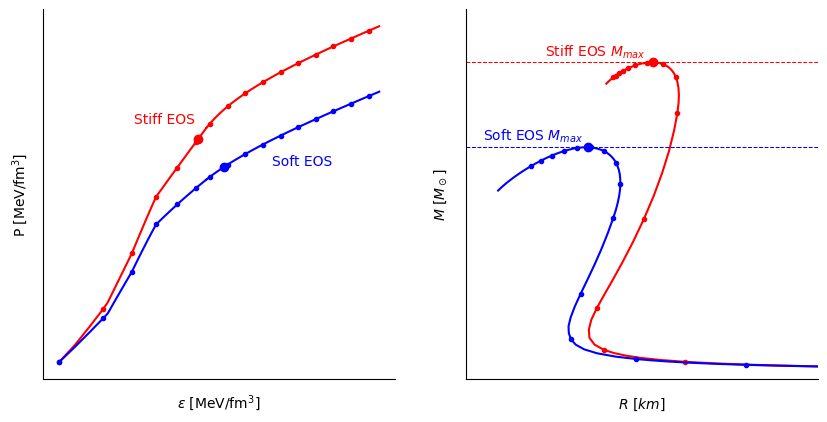

In [40]:
# Figure 1
# side-by-side p-ε and M-R plots of example stiff and soft EOSs (plotting)

# p-ε plot properties 
fig, (axpe, axmr) = plt.subplots(1, 2)
fig.set_figwidth(10)
axpe.set_xscale('log')
axpe.set_yscale('log')
axpe.set_xlabel(r'$\varepsilon$ [MeV/fm$^3$]')
axpe.set_ylabel(r'P [MeV/fm$^3$]')
axpe.spines["top"].set_visible(False)
axpe.spines["right"].set_visible(False)
axpe.set_xticks([])
axpe.set_yticks([])
axpe.tick_params(axis='both',which='both',bottom=False,left=False)

# plots example stiff and soft EOSs in p-ε space
axpe.plot(np.concatenate([eos_e_stiff,extra_e_stiff]), np.concatenate([eos_p_stiff,extra_p_stiff]),color='red',marker='.',markevery=np.arange(0,np.concatenate([eos_e_stiff,extra_e_stiff]).size,5))
axpe.plot(np.concatenate([eos_e_soft,extra_e_soft]), np.concatenate([eos_p_soft,extra_p_soft]),color='blue',marker='.',markevery=np.arange(0,np.concatenate([eos_e_soft,extra_e_soft]).size,5))
axpe.plot(e_range[m_arr_stiff==max(m_arr_stiff)],(interp1d(eos_e_stiff, eos_p_stiff))(e_range[m_arr_stiff==max(m_arr_stiff)]),marker='o',color='red')
axpe.plot(e_range[m_arr_soft==max(m_arr_soft)],(interp1d(extra_e_soft, extra_p_soft))(e_range[m_arr_soft==max(m_arr_soft)]),marker='o',color='blue')
axpe.text(240,2000,"Stiff EOS",color='red')
axpe.text(1500,500,"Soft EOS",color='blue')

# M-R plot properties 
axmr.set_xlabel(r'$R$ $[km]$',labelpad=12)
axmr.set_ylabel(r'$M$ $[M_\odot]$',labelpad=12)
axmr.spines["top"].set_visible(False)
axmr.spines["right"].set_visible(False)
axmr.set_xticks([])
axmr.set_yticks([])
axmr.set_xlim([10,20])
axmr.set_ylim([0,4.75])
axmr.tick_params(axis='both',which='both',bottom=False,left=False)

# plots example stiff and soft EOSs in M-R space
axmr.plot(R_arr_stiff,m_arr_stiff,color='red',marker='.',markevery=np.arange(0,np.concatenate([eos_e_stiff,extra_e_stiff]).size,5))
axmr.plot(R_arr_soft,m_arr_soft,color='blue',marker='.',markevery=np.arange(0,np.concatenate([eos_e_soft,extra_e_soft]).size,5))
axmr.plot(R_arr_stiff[m_arr_stiff==max(m_arr_stiff)],max(m_arr_stiff),marker='o',color='red')
axmr.plot(R_arr_soft[m_arr_soft==max(m_arr_soft)],max(m_arr_soft),marker='o',color='blue')
axmr.axhline(max(m_arr_stiff),linestyle='--',linewidth=0.75,color='red')
axmr.axhline(max(m_arr_soft),linestyle='--',linewidth=0.75,color='blue')
axmr.text(12.25,4.15,r'Stiff EOS $M_{max}$',color='red')
axmr.text(10.5,3.075,r'Soft EOS $M_{max}$',color='blue')

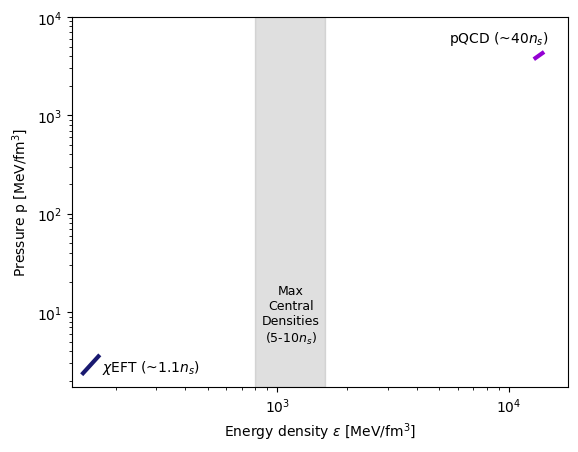

In [41]:
# Figure 3
# plot indicating our current understanding of the EOS with χEFT, pQCD, and the maximal central densities 
# replicated plot by Komoltsev & Kurkela (2022)

# plot properties
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([130,18000])
ax.set_ylim([1.75,10**4])
ax.set_xlabel(r"Energy density $\epsilon$ [MeV/fm$^3$]")
ax.set_ylabel(r"Pressure p [MeV/fm$^3$]")

# plot high- and low-density limits
ax.plot([ePQCD*10**3,-4284+6.87*2.65*10**3], [pPQCD*10**3,4284],linewidth=3,color='darkviolet')
ax.plot([144.8,eL*10**3], [2.392,pL*10**3],linewidth=3,color='midnightblue')

# plot maximal central densities region
ax.axvspan(800,1600,color='gray',alpha=0.25)

# text labels
ax.text(175,2.5,r"$\chi$EFT (~1.1$n_s$)")
ax.text(5500,5500,r"pQCD (~40$n_s$)")
ax.text(1140,5,"Max\nCentral\nDensities\n(5-10$n_s$)",ha='center',fontsize=9)

plt.show()

In [42]:
# calculates interpolations for each cs2lim value
pqcd_cs2_1 = kk2022interpolation(1,muPQCD,nPQCD,pPQCD,ePQCD)
pqcd_cs2_1_min = pe_to_mr(pqcd_cs2_1[0][0],pqcd_cs2_1[0][1])
pqcd_cs2_1_max = pe_to_mr(pqcd_cs2_1[1][0],pqcd_cs2_1[1][1])

pqcd_cs2_13 = kk2022interpolation(1./3,muPQCD,nPQCD,pPQCD,ePQCD)
pqcd_cs2_13_min = pe_to_mr(pqcd_cs2_13[0][0],pqcd_cs2_13[0][1])
pqcd_cs2_13_max = pe_to_mr(pqcd_cs2_13[1][0],pqcd_cs2_13[1][1])

pqcd_cs2_min_pe = kk2022interpolation(cs2_min(muPQCD,nPQCD,pPQCD,ePQCD),muPQCD,nPQCD,pPQCD,ePQCD,isMin=True)
pqcd_cs2_min = pe_to_mr(pqcd_cs2_min_pe[0][0],pqcd_cs2_min_pe[0][1])

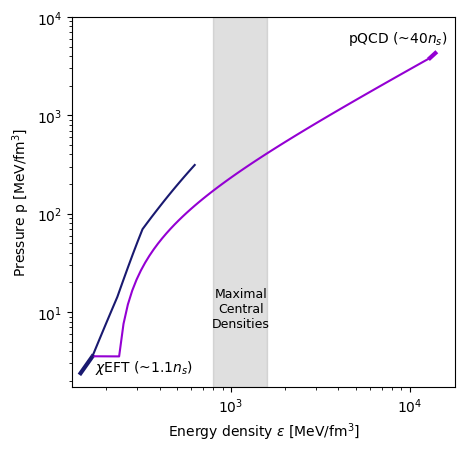

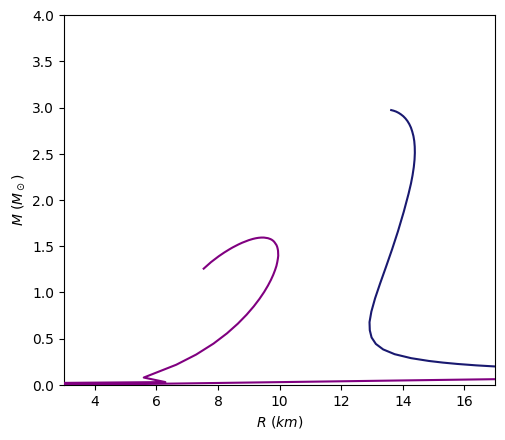

In [43]:
# Figure 2 (Poster)

# pressure-energy density plot properties
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([130,18000])
ax.set_ylim([1.75,10**4])
ax.set_xlabel(r"Energy density $\epsilon$ [MeV/fm$^3$]")
ax.set_ylabel(r"Pressure p [MeV/fm$^3$]")
ax.set_aspect(0.55)
plt.plot([ePQCD*10**3,-4284+6.87*2.65*10**3], [pPQCD*10**3,4284],linewidth=3,color='darkviolet')
plt.plot([144.8,eL*10**3], [2.392,pL*10**3],linewidth=3,color='midnightblue')

# plot maximal central densities region
ax.axvspan(800,1600,color='gray',alpha=0.25)

# text labels
ax.text(175,2.5,r"$\chi$EFT (~1.1$n_s$)")
ax.text(4500,5500,r"pQCD (~40$n_s$)")
ax.text(1140,7,"Maximal\nCentral\nDensities",ha='center',fontsize=9)

# plotting pressure-energy density EOS for χEFT extrapolation and for pQCD-χEFT interpolation
plt.plot(pqcd_cs2_min_pe[0][0],pqcd_cs2_min_pe[0][1],color='darkviolet')
plt.plot(eos_e_soft[5:],eos_p_soft[5:],color='midnightblue')

# mass-radius plot properties
fig, ax = plt.subplots()
ax.set_xlim([3,17])
ax.set_ylim([0,4])
ax.set_aspect(3)
ax.set_xlabel(r'$R$ $(km)$')
ax.set_ylabel(r'$M$ $(M_\odot)$')

# plotting mass-radius curves for χEFT extrapolation and for pQCD-χEFT interpolation
ax.plot(R_arr_soft[:-50], m_arr_soft[:-50],color='midnightblue')
ax.plot(np.concatenate([plot_data[0][1][2][0][0][0],plot_data[0][1][2][0][1][0]]),np.concatenate([plot_data[0][1][2][0][0][1],plot_data[0][1][2][0][1][1]]),zorder=100,color='purple')

In [44]:
# Figure 2 (Poster)



C:\Users\Tiffany\AppData\Local\Temp\ipykernel_8876\2634621652.py:19: RuntimeWarning: divide by zero encountered in divide
  n_min_causality = (mu**3*nPQCD-mu*muPQCD*(muPQCD*nPQCD-2*(pPQCD-pL)))/((mu**2-muL**2)*muPQCD)


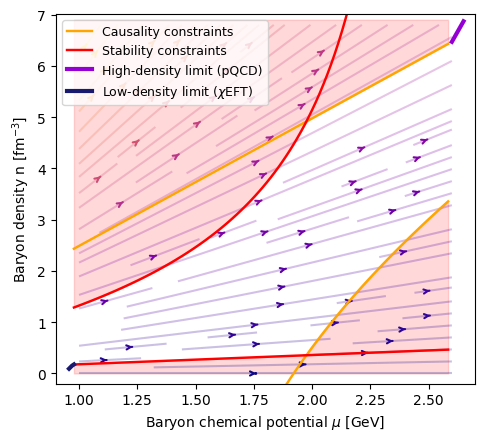

In [45]:
# Figure 5a
# Baryon density-baryon chemical potential plot
fig, ax = plt.subplots()

# vector field
MU, N = np.meshgrid(np.arange(1.0,2.7,0.1), np.arange(0.0,6.9,0.2))
dn = N/MU
dmu = np.ones(dn.shape)
sp = plt.streamplot(MU,N,dmu,dn,density=1, arrowstyle="->", arrowsize=0.75, color=dn,cmap='plasma')
sp.lines.set_alpha(0.25)

# calculates interpolation values
mu = np.arange(muL,muPQCD,(muPQCD-muL)/100)

n_max_pressure = (mu**3*nL-mu*muL*(muL*nL+2*(pPQCD-pL)))/((mu**2-muPQCD**2)*muL)
n_max_causality = nPQCD*(mu/muPQCD)

n_min_pressure = nL*(mu/muL)
n_min_causality = (mu**3*nPQCD-mu*muPQCD*(muPQCD*nPQCD-2*(pPQCD-pL)))/((mu**2-muL**2)*muPQCD)

# plots causality and stability constraints
plt.plot(mu,n_max_causality,c="orange",linewidth=1.75,label='Causality constraints')
plt.plot(mu,n_min_causality,c="orange",linewidth=1.75)

plt.plot(mu,n_max_pressure,c="red",linewidth=1.75,label='Stability constraints')
plt.plot(mu,n_min_pressure,c="red",linewidth=1.75)

# calculates intersection of causality and stability constaints
idxc = np.argwhere(np.diff(np.sign(n_max_pressure - n_max_causality))).flatten()[0]

# shades region outside of the allowed region red
eos_max = np.minimum(n_max_pressure, n_max_causality)
eos_min = np.maximum(n_min_pressure, n_min_causality)
ax.fill_between(mu,eos_max,6.9,color='red',alpha=0.15)
ax.fill_between(mu,eos_min,0.0,color='red',alpha=0.15)

# plots high- and low-density limits
plt.plot([muPQCD,2.65], [nPQCD,6.87],c="darkviolet",linewidth=3,label="High-density limit (pQCD)")
plt.plot([0.957,0.97,0.975,muL], [0.092672,0.152,0.167,nL],c="midnightblue",linewidth=3,label=r"Low-density limit ($\chi$EFT)")

# plot properties
fig.dpi = 100
ax.set_xlim([0.9, 2.7])
ax.set_ylim([-0.2, 7.01])
ax.set_aspect(0.22)
ax.set_xlabel(r"Baryon chemical potential $\mu$ [GeV]")
ax.set_ylabel(r"Baryon density n [fm$^{-3}$]")
ax.legend(loc='upper left',fontsize=9)
plt.show()

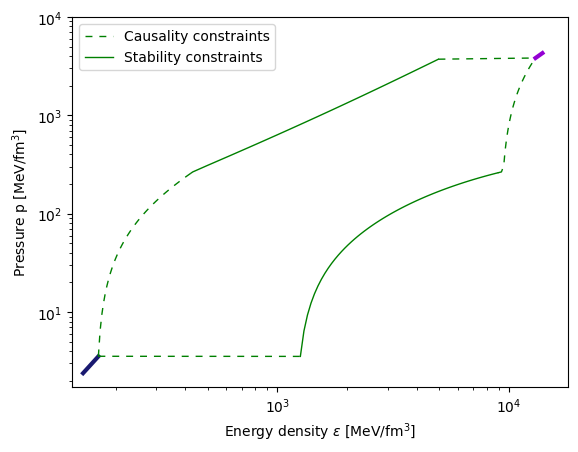

In [46]:
# Figure 4

# plot properties
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([130,18000])
ax.set_ylim([1.75,10**4])
ax.set_xlabel(r"Energy density $\epsilon$ [MeV/fm$^3$]")
ax.set_ylabel(r"Pressure p [MeV/fm$^3$]")
plt.plot([ePQCD*10**3,-4284+6.87*2.65*10**3], [pPQCD*10**3,4284],linewidth=3,color='darkviolet')
plt.plot([144.8,eL*10**3], [2.392,pL*10**3],linewidth=3,color='midnightblue')

# plots causality constraints
plt.plot(pqcd_cs2_1[0][0][idxc:],pqcd_cs2_1[0][1][idxc:],color='green',linewidth=1,linestyle='--',dashes=(5, 5),label='Causality constraints')
plt.plot(pqcd_cs2_1[1][0][:idxc],pqcd_cs2_1[1][1][:idxc],color='green',linewidth=1,linestyle='--',dashes=(5, 5))

# plots stability constraints
plt.plot(pqcd_cs2_1[0][0][1:idxc+1],pqcd_cs2_1[0][1][1:idxc+1],color='green',linewidth=1,label='Stability constraints')
plt.plot(pqcd_cs2_1[1][0][idxc-1:-1],pqcd_cs2_1[1][1][idxc-1:-1],color='green',linewidth=1)

# plots horizontal lines connecting to high- and low-density limits
plt.plot(pqcd_cs2_1[0][0][0:2],pqcd_cs2_1[0][1][0:2],color='green',linewidth=1,linestyle='--',dashes=(5, 5))
plt.plot(pqcd_cs2_1[1][0][-2:len(pqcd_cs2_1[1][0])],pqcd_cs2_1[1][1][-2:len(pqcd_cs2_1[1][0])],color='green',linewidth=1,linestyle='--',dashes=(5, 5))

# creates legend
ax.legend(loc='upper left')

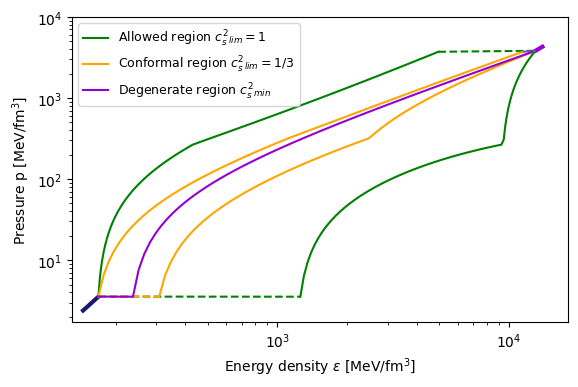

In [47]:
# Figure 5
# Komoltsev & Kurkela (2022) pQCD-χEFT interpolation pressure-energy density plot
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([130,18000])
ax.set_ylim([1.75,10**4])
ax.set_xlabel(r"Energy density $\epsilon$ [MeV/fm$^3$]")
ax.set_ylabel(r"Pressure p [MeV/fm$^3$]")
ax.set_aspect(0.35)
plt.plot([ePQCD*10**3,-4284+6.87*2.65*10**3], [pPQCD*10**3,4284],linewidth=3,color='darkviolet')
plt.plot([144.8,eL*10**3], [2.392,pL*10**3],linewidth=3,color='midnightblue')

plt.plot(pqcd_cs2_1[0][0][1:],pqcd_cs2_1[0][1][1:],color='green',label=r'Allowed region $c_s^2$$_{lim} = 1$')
plt.plot(pqcd_cs2_1[1][0][:-1],pqcd_cs2_1[1][1][:-1],color='green')
plt.plot(pqcd_cs2_1[0][0][0:2],pqcd_cs2_1[0][1][0:2],color='green',linestyle='--')
plt.plot(pqcd_cs2_1[1][0][-2:len(pqcd_cs2_1[1][0])],pqcd_cs2_1[1][1][-2:len(pqcd_cs2_1[1][0])],color='green',linestyle='--')

plt.plot(pqcd_cs2_13[0][0][1:],pqcd_cs2_13[0][1][1:],color='orange',label=r'Conformal region $c_s^2$$_{lim} = 1/3$')
plt.plot(pqcd_cs2_13[1][0][:-1],pqcd_cs2_13[1][1][:-1],color='orange')
plt.plot(pqcd_cs2_13[0][0][0:2],pqcd_cs2_13[0][1][0:2],color='orange',linestyle='--')
plt.plot(pqcd_cs2_13[1][0][-2:len(pqcd_cs2_13[1][0])],pqcd_cs2_13[1][1][-2:len(pqcd_cs2_13[1][0])],color='slateblue',linestyle='--')

plt.plot(pqcd_cs2_min_pe[0][0],pqcd_cs2_min_pe[0][1],color='darkviolet',label=r'Degenerate region $c_s^2$$_{min}$')

ax.legend(loc='upper left',fontsize=9)

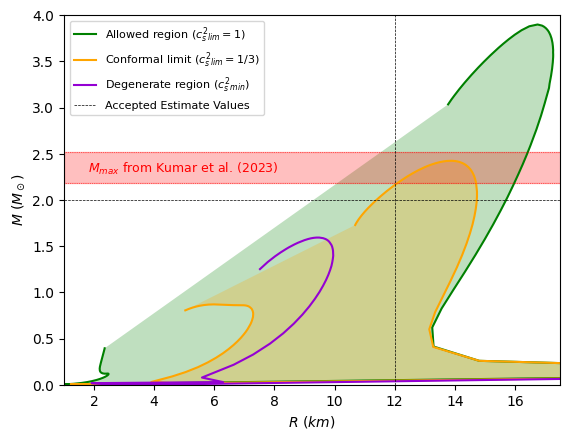

In [48]:
# Figure 6
# Komoltsev & Kurkela (2022) pQCD-χEFT interpolation mass radius plot

# plot properties
fig, ax = plt.subplots()
ax.set_xlim([1,17.5])
ax.set_ylim([0,4])
ax.set_xlabel(r'$R$ $(km)$')
ax.set_ylabel(r'$M$ $(M_\odot)$')

# plots interpolations for cs2lim = 1
ax.plot(np.concatenate([pqcd_cs2_1_min[0][0],pqcd_cs2_1_min[1][0]]),np.concatenate([pqcd_cs2_1_min[0][1],pqcd_cs2_1_min[1][1]]),color='green',label=r'Allowed region ($c_s^2$$_{lim}=1$)')
ax.plot(np.concatenate([pqcd_cs2_1_max[0][0],pqcd_cs2_1_max[1][0]]),np.concatenate([pqcd_cs2_1_max[0][1],pqcd_cs2_1_max[1][1]]),color='green')
ax.fill(np.concatenate([pqcd_cs2_1_min[1][0][::-1],pqcd_cs2_1_min[0][0][::-1],pqcd_cs2_1_max[0][0],pqcd_cs2_1_max[1][0]]),
        np.concatenate([pqcd_cs2_1_min[1][1][::-1],pqcd_cs2_1_min[0][1][::-1],pqcd_cs2_1_max[0][1],pqcd_cs2_1_max[1][1]]),'green',alpha=0.25)

# plots interpolations for cs2lim = 1/3
ax.plot(np.concatenate([pqcd_cs2_13_min[0][0],pqcd_cs2_13_min[1][0]]),np.concatenate([pqcd_cs2_13_min[0][1],pqcd_cs2_13_min[1][1]]),color='orange',label=r'Conformal limit ($c_s^2$$_{lim}=1/3$)')
ax.plot(np.concatenate([pqcd_cs2_13_max[0][0],pqcd_cs2_13_max[1][0]]),np.concatenate([pqcd_cs2_13_max[0][1],pqcd_cs2_13_max[1][1]]),color='orange')
ax.fill(np.concatenate([pqcd_cs2_13_min[1][0][::-1],pqcd_cs2_13_min[0][0][::-1],pqcd_cs2_13_max[0][0],pqcd_cs2_13_max[1][0]]),
        np.concatenate([pqcd_cs2_13_min[1][1][::-1],pqcd_cs2_13_min[0][1][::-1],pqcd_cs2_13_max[0][1],pqcd_cs2_13_max[1][1]]),'orange',alpha=0.25)

# plots interpolations for cs2min
ax.plot(np.concatenate([pqcd_cs2_min[0][0],pqcd_cs2_min[1][0]]),np.concatenate([pqcd_cs2_min[0][1],pqcd_cs2_min[1][1]]),color='darkviolet',label=r'Degenerate region ($c_s^2$$_{min}$)')

# plots observed Mmax
ax.axhline(2.52,linestyle='dotted',linewidth=0.5,color='red')
ax.axhline(2.18,linestyle='dotted',linewidth=0.5,color='red')
ax.fill_between(x=np.arange(1,20),y1=2.18,y2=2.52,color='red',alpha=0.25)
ax.text(1.8,2.3,r'$M_{max}$ from Kumar et al. (2023)',fontsize=9,color='red')

# plots accepted estimate values
ax.axhline(2.0,linestyle='dashed',linewidth=0.5,color='black',label='Accepted Estimate Values')
ax.axvline(12,linestyle='dashed',linewidth=0.5,color='black')

# creates legend
ax.legend(loc='upper left',fontsize=8)


C:\Users\Tiffany\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\scale.py:253: RuntimeWarning: overflow encountered in power
  return np.power(self.base, a)
C:\Users\Tiffany\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\axes\_base.py:2914: RuntimeWarning: overflow encountered in scalar subtract
  delta = (x1t - x0t) * margin


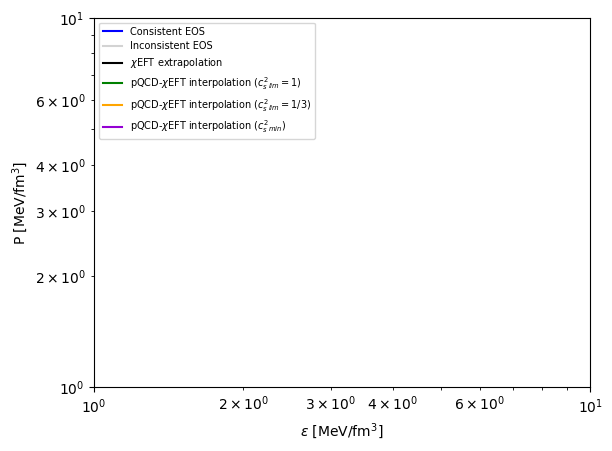

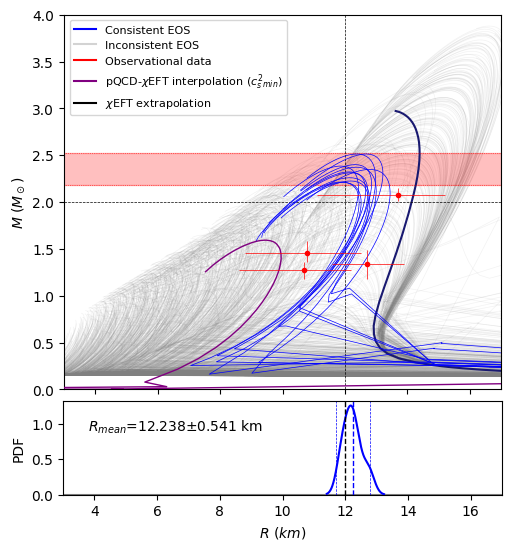

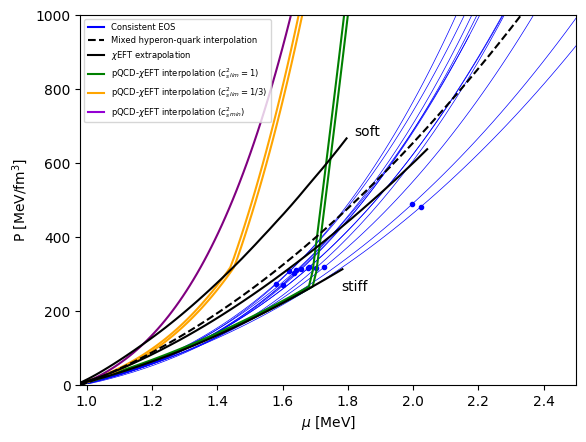

In [49]:
# Figure 8 and 9
# plots of EOSs consistent and inconsistent with observational data and compared to past models

# select the cs2lim of the EOSs 
# cs2lim = 0 # 1
cs2lim = 1 # 1/3
# cs2lim = 2 # min

# creates p-ε, M-R, and p-μ plots
fig_pe, ax_pe = plt.subplots()
fig_mr = plt.figure(figsize=(12, 6))
gs = fig_mr.add_gridspec(2,2, width_ratios=(1, 1), height_ratios=(4, 1), left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.05, hspace=0.05)
ax_mr = fig_mr.add_subplot(gs[0,0])
fig_pm, ax_pm = plt.subplots()

# constants to help calculate baryon density of high-density limit from the generated EOS data
n = math.ceil(plot_data[-1][0]**(1/3)) 
dn = 0.16*40/n 

# empty arrays for the data to collect from the EOSs consistent with observational data
rmax_data_min, rmax_consistent_data, cs2min_consistent_data, nmax_consistent_data, r_14_predictions = [], [], [], [], []

# loops through all EOSs, identifies those consistent with observational data, and collects its properties
for eos in plot_data:
    nH = 0.16*10+dn*(eos[0]%n)

    # plots pQCD-χEFT interpolation
    if eos[0] < 0:
        for cs2lim in range(3):
            r_min = eos[1][cs2lim][0][1][0]
            m_min = eos[1][cs2lim][0][1][1]
            e_min = eos[1][cs2lim][0][2][0]
            p_min = eos[1][cs2lim][0][2][1]
            if cs2lim == 0: color = 'green'
            elif cs2lim == 1: color = 'orange'
            else: color = 'purple'

            mu = np.linspace(start=muL, stop=(e_min[-1]+p_min[-1])/nH/10**3, num=100)
            if cs2lim == 2: 
                idx_mmax_min = m_min.argmax()-100
                rmax_data_min.append(r_min[idx_mmax_min])
                ax_pe.plot(e_min[idx_mmax_min],p_min[idx_mmax_min],marker='.',color=color,zorder=50)

                # collects the value of cs2lim
                muH=(e_min[-1]+p_min[-1])/nH/10**3
                pH = p_min[-1]/10**3
                eH = e_min[-1]/10**3
                cs2_lim_min = cs2_min(muH,nH,pH,eH)

                # collects the value of n at the maximum mass
                muc = (muH**(1/cs2lim)*(cs2lim*(muL*nL-muH*nH+pH-pL)+pH-pL))/(cs2lim*(nL*(muH/muL)**(1/cs2lim)-nH))
                mu1 = mu[mu<=muc]
                mu2 = mu[mu>muc]
                n_min = np.concatenate([nL*(mu1/muL)**(1/cs2_lim_min),(mu2/muL)**(1/cs2_lim_min)*(cs2_lim_min*(mu2*nH*(mu2/muH)**(1/cs2_lim_min)-muH*nH+(pH-pL))+(pH-pL))/(cs2_lim_min*(mu2*(mu2/muL)**(1/cs2_lim_min)-muL))])

                ax_mr.plot(np.concatenate([eos[1][cs2lim][0][0][0],r_min]),np.concatenate([eos[1][cs2lim][0][0][1],m_min]),linewidth=1,zorder=100,color='purple')
            ax_pe.plot(e_min,p_min,color=color,zorder=50,linewidth=1)
            ax_pm.plot(mu,p_min,color=color)

            if cs2lim != 2:
                m_max = eos[1][cs2lim][1][1][1]
                e_max = eos[1][cs2lim][1][2][0]
                p_max = eos[1][cs2lim][1][2][1]
                idx_mmax_max = m_max.argmax()-100
                ax_pe.plot(e_max[idx_mmax_max],p_max[idx_mmax_max],color=color,zorder=50)
                ax_pe.plot(np.concatenate([eos[1][cs2lim][1][2][0],[e_min[-1]]]),np.concatenate([eos[1][cs2lim][1][2][1],[eos[1][cs2lim][1][2][1][-1]]]),color=color,zorder=50,linewidth=0.75)
                ax_pm.plot(mu,p_max,color=color)
        continue

    # loads data of current EOS
    e_min, p_min = eos[1][cs2lim][0][2][0], eos[1][cs2lim][0][2][1]
    r_min, m_min = eos[1][cs2lim][0][1][0], eos[1][cs2lim][0][1][1]

    # determines whether the EOS is consistent with observational data
    if (max(e_min) > 100 and max(p_min) > 1 and (cs2lim == 2 or (max(e_max) > 100 and max(p_max) > 1))):
        idx_mmax_min = m_min.argmax()
        rmax_data_min.append(r_min[idx_mmax_min])
        isConsistent = True
        for index, row in df.iterrows():
            if (not (max(m_min) < 2.52 and (max(m_min) > 2.18) and 
                any(m_min[i] < row['mass']+row['mass upper error'] and m_min[i] > row['mass']-row['mass lower error']
                    and r_min[i] < row['radius']+row['radius upper error'] and r_min[i] > row['radius']-row['radius lower error'] 
                    for i in range(m_min.size)))):
                isConsistent = False
        
        # collects data from EOSs consistent with observational data and plots all EOSs
        if (isConsistent):
            # collects the radius at the maximum mass and at the mass of 1.4 solar masses
            ax_mr.plot(np.concatenate([eos[1][cs2lim][0][0][0],r_min[m_min>0.15]]),np.concatenate([eos[1][cs2lim][0][0][1],m_min[m_min>0.15]]),color='blue',zorder=50,linewidth=0.5)
            rmax_consistent_data.append(r_min[idx_mmax_min])
            r_14_predictions.append((interp1d(np.concatenate([eos[1][cs2lim][0][0][1],m_min[m_min>0.15]]),np.concatenate([eos[1][cs2lim][0][0][0],r_min[m_min>0.15]])))(1.4))

            # collects the value of cs2lim
            muH=(e_min[-1]+p_min[-1])/nH/10**3
            pH = p_min[-1]/10**3
            eH = e_min[-1]/10**3
            cs2_lim_min = cs2_min(muH,nH,pH,eH)
            cs2min_consistent_data.append(cs2_lim_min)

            # collects the value of n at the maximum mass
            mu = np.linspace(start=muL, stop=muH, num=100)
            muc = (muH**(1/cs2lim)*(cs2lim*(muL*nL-muH*nH+pH-pL)+pH-pL))/(cs2lim*(nL*(muH/muL)**(1/cs2lim)-nH))
            mu1 = mu[mu<=muc]
            mu2 = mu[mu>muc]
            n_min = np.concatenate([nL*(mu1/muL)**(1/cs2_lim_min),(mu2/muL)**(1/cs2_lim_min)*(cs2_lim_min*(mu2*nH*(mu2/muH)**(1/cs2_lim_min)-muH*nH+(pH-pL))+(pH-pL))/(cs2_lim_min*(mu2*(mu2/muL)**(1/cs2_lim_min)-muL))])
            nmax_consistent_data.append(n_min[idx_mmax_min])

            # plots EOS in blue
            ax_pe.plot(e_min,p_min,color='blue',zorder=100,linewidth=0.5)
            ax_pe.plot(e_min[idx_mmax_min],p_min[idx_mmax_min],marker='.',color='blue',zorder=100,markersize=5)

            # plots p-μ in blue
            ax_pm.plot(mu,p_min,color='blue',linewidth=0.5,zorder=-20)
            ax_pm.plot(mu[idx_mmax_min],p_min[idx_mmax_min],marker='.',color='blue',linewidth=0.5,zorder=-20)

        else: 
            # plots EOS in gray
            ax_mr.plot(np.concatenate([eos[1][cs2lim][0][0][0],r_min[m_min>0.15]]),np.concatenate([eos[1][cs2lim][0][0][1],m_min[m_min>0.15]]),color='gray',alpha=0.1,zorder=0,linewidth=0.5)
            ax_pe.plot(e_min,p_min,color='gray',zorder=0,alpha=0.1,linewidth=0.25)
            ax_pe.plot(e_min[idx_mmax_min],p_min[idx_mmax_min],color='gray',zorder=0,alpha=0.1,markersize=3)
ax_mr.plot(R_arr_soft[:-50], m_arr_soft[:-50],color='midnightblue')

# p-ε plot properties
ax_pe.set_xscale('log')
ax_pe.set_yscale('log')
ax_pe.set_xlabel(r'$\varepsilon$ [MeV/fm$^3$]')
ax_pe.set_ylabel(r'P [MeV/fm$^3$]')
ax_pe.plot([144.8,eL*10**3], [2.392,pL*10**3],linewidth=3,color='midnightblue')
ax_pe.plot([ePQCD*10**3,-4284+6.87*2.65*10**3], [pPQCD*10**3,4284],linewidth=3,color='darkviolet',zorder=10**6)
ax_pe.set_xlim(ax_pe.get_xlim())
ax_pe.set_ylim(ax_pe.get_ylim())

# M-R plot properties
ax_mr.set_xlim([3,17])
ax_mr.set_ylim([0,4])
ax_mr.set_aspect(3)
ax_mr.tick_params(axis="x", labelbottom=False)
ax_mr_sub = fig_mr.add_subplot(gs[1,0], sharex=ax_mr)
ax_mr_sub.set_xlabel(r'$R$ $(km)$')
ax_mr_sub.set_xlabel(r'$R$ $(km)$')
ax_mr.set_ylabel(r'$M$ $(M_\odot)$')
ax_mr_sub.set_xlim([3,17])
ax_mr_sub.set_aspect(2.27)

# p-μ plot properties
ax_pm.set_xlabel(r'$\mu$ [MeV]')
ax_pm.set_ylabel(r'P [MeV/fm$^3$]')
ax_pm.set_xlim([0.980,2.5])
ax_pm.set_ylim([0,1000])

# creates p-ε color legend
ax_pe.plot(0,0,color='blue',label='Consistent EOS')
ax_pe.plot(0,0,color='lightgray',label='Inconsistent EOS')
ax_pe.plot(0,0,color='black',label=r'$\chi$EFT extrapolation')
ax_pe.plot(0,0,color='green',label=r'pQCD-$\chi$EFT interpolation ($c_s^2$$_{lim}=1$)')
ax_pe.plot(0,0,color='orange',label=r'pQCD-$\chi$EFT interpolation ($c_s^2$$_{lim}=1/3$)')
ax_pe.plot(0,0,color='darkviolet',label=r'pQCD-$\chi$EFT interpolation ($c_s^2$$_{min}$)')
ax_pe.legend(loc='upper left',fontsize=7)
ax_pe.axvspan(800,1600,color='lightgray',alpha=0.25,zorder=-10)

# creates M-R color legend
ax_mr.plot(0,0,color='blue',label='Consistent EOS')
ax_mr.plot(0,0,color='lightgray',label='Inconsistent EOS')
ax_mr.plot(0,0,color='red',label='Observational data')
ax_mr.plot(0,0,color='purple',label=r'pQCD-$\chi$EFT interpolation ($c_s^2$$_{min}$)')
ax_mr.plot(0,0,color='black',label=r'$\chi$EFT extrapolation')
ax_mr.legend(loc='upper left',fontsize=8)

# creates p-μ color legend
ax_pm.plot(0,0,color='blue',label='Consistent EOS')
ax_pm.plot(0,0,color='black',linestyle='dashed',label='Mixed hyperon-quark interpolation')
ax_pm.plot(0,0,color='black',label=r'$\chi$EFT extrapolation')
ax_pm.plot(0,0,color='green',label=r'pQCD-$\chi$EFT interpolation ($c_s^2$$_{lim}=1$)')
ax_pm.plot(0,0,color='orange',label=r'pQCD-$\chi$EFT interpolation ($c_s^2$$_{lim}=1/3$)')
ax_pm.plot(0,0,color='darkviolet',label=r'pQCD-$\chi$EFT interpolation ($c_s^2$$_{min}$)')
ax_pm.legend(loc='upper left',fontsize=6)

# plots χEFT extrapolation
ax_pe.plot(hlps_stiff['e[MeV/fm^3]'],hlps_stiff['p[MeV/fm^3]'],color='black',linewidth=0.9,zorder=150)
ax_pe.plot(hlps_intermed['e[MeV/fm^3]'],hlps_intermed['p[MeV/fm^3]'],color='black',linewidth=0.9,zorder=150)
ax_pe.plot(hlps_soft['e[MeV/fm^3]'],hlps_soft['p[MeV/fm^3]'],color='black',linewidth=0.9,zorder=150)

# plots observed Mmax
ax_mr.axhline(2.52,linestyle='dotted',linewidth=0.5,color='red')
ax_mr.axhline(2.18,linestyle='dotted',linewidth=0.5,color='red')
ax_mr.fill_between(x=np.arange(1,20),y1=2.18,y2=2.52,color='red',alpha=0.25)

# plots observational data points
ax_mr.errorbar(df['radius'],df['mass'],xerr=[df['radius upper error'],df['radius lower error']],yerr=[df['mass lower error'],df['mass upper error']],color='red',fmt='.',linewidth=0.5,zorder=100)

ax_mr.axhline(2.0,linestyle='dashed',linewidth=0.5,color='black')
ax_mr.axvline(12,linestyle='dashed',linewidth=0.5,color='black')

# plots Rmax distribution plot
pd.Series(rmax_data_min).plot.density(color='gray', ax=ax_mr_sub)
pd.Series(rmax_consistent_data).plot.density(color='blue', ax=ax_mr_sub)
ax_mr_sub.axvline(np.array(rmax_consistent_data).mean(),linewidth=1,linestyle='dashed',color='blue')
ax_mr_sub.axvline(np.array(rmax_consistent_data).mean()-1.96*np.array(rmax_consistent_data).std(),linewidth=0.5,linestyle='dashed',color='blue')
ax_mr_sub.axvline(np.array(rmax_consistent_data).mean()+1.96*np.array(rmax_consistent_data).std(),linewidth=0.5,linestyle='dashed',color='blue')
ax_mr_sub.axvline(12,linewidth=1,linestyle='dashed',color='black')
ax_mr_sub.set_ylabel('PDF') 
ax_mr_sub.set_ylim([0,ax_mr_sub.get_ylim()[1]])
ax_mr_sub.text(3.8,0.9,r'$R_{mean}$='+str('{0:.3f}'.format(sum(rmax_consistent_data)/len(rmax_consistent_data)))+
               r'$\pm$'+ str('{0:.3f}'.format(1.96*np.array(rmax_consistent_data).std()))+' km')

# plots χEFT extrapolation and mixed hyperon-quark model for p-μ plot
ax_pm.plot((hlps_stiff['p[MeV/fm^3]']+hlps_stiff['e[MeV/fm^3]'])/(0.16*10**3*hlps_stiff['n/n_0']),hlps_stiff['p[MeV/fm^3]'],color='black')
ax_pm.plot((hlps_intermed['p[MeV/fm^3]']+hlps_intermed['e[MeV/fm^3]'])/(0.16*10**3*hlps_intermed['n/n_0']),hlps_intermed['p[MeV/fm^3]'],color='black')
ax_pm.plot((hlps_soft['p[MeV/fm^3]']+hlps_soft['e[MeV/fm^3]'])/(0.16*10**3*hlps_soft['n/n_0']),hlps_soft['p[MeV/fm^3]'],color='black')
ax_pm.plot(mu,296.2*mu**2-238.9*mu-52.40,color='black',linestyle='dashed',zorder=20) # calculated from Shahrbaf et al. (2020)

# labels χEFT extrapolations
ax_pm.text(1.78,255,"stiff")
ax_pm.text(1.82,675,"soft")

plt.show()

In [50]:
# prints properties of consistent EOSs

# number
print("n", len(rmax_consistent_data))

# mean and standard deviation of radii for maximum mass
rmax_consistent_data = np.array(rmax_consistent_data)
print("Rmax", rmax_consistent_data.mean(), "±", rmax_consistent_data.std())

# mean and standard deviation of radii for mass of 1.4 solar masses
r_14_predictions = np.array(r_14_predictions)
print("R1.4", r_14_predictions.mean(), "±", r_14_predictions.std())

# mean and standard deviation of cs2min
cs2min_consistent_data=np.array(cs2min_consistent_data)
print("cs2min",cs2min_consistent_data.mean(), "±", cs2min_consistent_data.std())

# mean and standard deviation of nmax
nmax_consistent_data=np.array(nmax_consistent_data)
print("nmax",nmax_consistent_data.mean(), "±", nmax_consistent_data.std())

# mean and standard deviation of nmax in terms of the nuclear saturation density (ns)
nmax_ns_consistent_data = nmax_consistent_data/0.16
print("nmax (ns)",nmax_ns_consistent_data.mean(), "±", nmax_ns_consistent_data.std())

n 12
Rmax 12.23775 ± 0.2757840716333461
R1.4 11.994274846897177 ± 0.2763342307201462
cs2min 0.4347278565324468 ± 0.07378658964674793
nmax 0.6386315683770419 ± 0.033246215936647776
nmax (ns) 3.9914473023565122 ± 0.2077888496040486
